In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
from utils import *
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
import scipy.optimize #fmin_cg to train neural network
import itertools
from scipy.special import expit #Vectorized sigmoid function

In [4]:
test_df = data_df[(data_df.date > "2015-01-01") & (data_df.date < "2016-01-01")]
test_df2 = data_df[data_df.date > "2016-01-01"]
data_df = data_df[data_df.date < "2015-01-01"]

In [68]:
data_df = test_df

In [69]:
df = pd.DataFrame(index=data_df.index)

In [70]:
columns = ["yz0","yz1","minute","minute2","isnew","opentop0","opentop1","opentop2","reachtop1","top0","top1","foot0","foot1","foot2","jump1","jump2","speedup1","speedup2"]

In [71]:
for column in columns:
    df[column] = eval(column).astype(int)

In [72]:
df["volume_ratio"] = data_df["minute_volume"] / data_df["volume1"]
df["low2/close1"] = data_df["low2"] / data_df["close1"]
df["volume1/volume0"] = data_df["volume1"] / data_df["volume0"]

In [73]:
change_se = data_df["change"].copy()
print change_se.head(3)
change_se[change_se <= 1.000000] = 1 
change_se[change_se > 1.000000] = 2
print change_se.head(3)

000002.XSHE_2015-01-05    0.954866
000002.XSHE_2015-12-02    1.012000
000002.XSHE_2015-12-18    0.899787
Name: change, dtype: float64
000002.XSHE_2015-01-05    1.0
000002.XSHE_2015-12-02    2.0
000002.XSHE_2015-12-18    1.0
Name: change, dtype: float64


In [74]:
X = df.as_matrix()
y = change_se.as_matrix()
#Insert a column of 1's to X as usual
X = np.insert(X,0,1,axis=1)
print "'y' shape: %s. Unique elements in y: %s"%(y.shape,np.unique(y))
print "'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape)

'y' shape: (12778,). Unique elements in y: [ 1.  2.]
'X' shape: (12778, 22). X[0] shape: (22,)


In [12]:
# These are some global variables I'm suing to ensure the sizes
# of various matrices are correct
#these are NOT including bias nits
input_layer_size = 21
hidden_layer_size = 7
output_layer_size = 2 
n_training_samples = X.shape[0]

In [13]:
#Some utility functions. There are lot of flattening and
#reshaping of theta matrices, the input X matrix, etc...
#Nicely shaped matrices make the linear algebra easier when developing,
#but the minimization routine (fmin_cg) requires that all inputs

def flattenParams(thetas_list):
    """
    Hand this function a list of theta matrices, and it will flatten it
    into one long (n,1) shaped numpy array
    """
    flattened_list = [ mytheta.flatten() for mytheta in thetas_list ]
    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + \
                            (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined),1))

def reshapeParams(flattened_array):
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size+1))
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size+1))
    
    return [ theta1, theta2 ]

def flattenX(myX):
    return np.array(myX.flatten()).reshape((n_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size+1))

In [14]:
def computeCost(mythetas_flattened,myX_flattened,myy,mylambda=0.):
    """
    This function takes in:
        1) a flattened vector of theta parameters (each theta would go from one
           NN layer to the next), the thetas include the bias unit.
        2) the flattened training set matrix X, which contains the bias unit first column
        3) the label vector y, which has one column
    It loops over training points (recommended by the professor, as the linear
    algebra version is "quite complicated") and:
        1) constructs a new "y" vector, with 10 rows and 1 column, 
            with one non-zero entry corresponding to that iteration
        2) computes the cost given that y- vector and that training point
        3) accumulates all of the costs
        4) computes a regularization term (after the loop over training points)
    """
    
    # First unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)
    
    # Now unroll X
    myX = reshapeX(myX_flattened)
    
    #This is what will accumulate the total cost
    total_cost = 0.
    
    m = n_training_samples

    # Loop over the training points (rows in myX, already contain bias unit)
    for irow in xrange(m):
        myrow = myX[irow]
                
        # First compute the hypothesis (this is a (10,1) vector
        # of the hypothesis for each possible y-value)
        # propagateForward returns (zs, activations) for each layer
        # so propagateforward[-1][1] means "activation for -1st (last) layer"
        myhs = propagateForward(myrow,mythetas)[-1][1]

        # Construct a 10x1 "y" vector with all zeros and only one "1" entry
        # note here if the hand-written digit is "0", then that corresponds
        # to a y- vector with 1 in the 10th spot (different from what the
        # homework suggests)
        tmpy  = np.zeros((output_layer_size,1))
        tmpy[int(myy[irow]-1)] = 1
        
        # Compute the cost for this point and y-vector
        mycost = -tmpy.T.dot(np.log(myhs))-(1-tmpy.T).dot(np.log(1-myhs))
     
        # Accumulate the total cost
        total_cost += mycost
  
    # Normalize the total_cost, cast as float
    total_cost = float(total_cost) / m
    
    # Compute the regularization term
    total_reg = 0.
    for mytheta in mythetas:
        total_reg += np.sum(mytheta*mytheta) #element-wise multiplication
    total_reg *= float(mylambda)/(2*m)
        
    return total_cost + total_reg
       

def propagateForward(row,Thetas):
    """
    Function that given a list of Thetas (NOT flattened), propagates the
    row of features forwards, assuming the features ALREADY
    include the bias unit in the input layer, and the 
    Thetas also include the bias unit

    The output is a vector with element [0] for the hidden layer,
    and element [1] for the output layer
        -- Each element is a tuple of (zs, as)
        -- where "zs" and "as" have shape (# of units in that layer, 1)
    
    ***The 'activations' are the same as "h", but this works for many layers
    (hence a vector of thetas, not just one theta)
    Also, "h" is vectorized to do all rows at once...
    this function takes in one row at a time***
    """
   
    features = row
    zs_as_per_layer = []
    for i in xrange(len(Thetas)):  
        Theta = Thetas[i]
        #Theta is (25,401), features are (401, 1)
        #so "z" comes out to be (25, 1)
        #this is one "z" value for each unit in the hidden layer
        #not counting the bias unit
        z = Theta.dot(features).reshape((Theta.shape[0],1))
        a = expit(z)
        zs_as_per_layer.append( (z, a) )
        if i == len(Thetas)-1:
            return np.array(zs_as_per_layer)
        a = np.insert(a,0,1) #Add the bias unit
        features = a

In [15]:
def genRandThetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

In [16]:
def sigmoidGradient(z):
    dummy = expit(z)
    return dummy*(1-dummy)

In [17]:
def backPropagate(mythetas_flattened,myX_flattened,myy,mylambda=0.):
    
    # First unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)
    
    # Now unroll X
    myX = reshapeX(myX_flattened)

    #Note: the Delta matrices should include the bias unit
    #The Delta matrices have the same shape as the theta matrices
    Delta1 = np.zeros((hidden_layer_size,input_layer_size+1))
    Delta2 = np.zeros((output_layer_size,hidden_layer_size+1))

    # Loop over the training points (rows in myX, already contain bias unit)
    m = n_training_samples
    for irow in xrange(m):
        myrow = myX[irow]
        a1 = myrow.reshape((input_layer_size+1,1))
        # propagateForward returns (zs, activations) for each layer excluding the input layer
        temp = propagateForward(myrow,mythetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        tmpy = np.zeros((output_layer_size,1))
        tmpy[int(myy[irow]-1)] = 1
        delta3 = a3 - tmpy 
        delta2 = mythetas[1].T[1:,:].dot(delta3)*sigmoidGradient(z2) #remove 0th element
        a2 = np.insert(a2,0,1,axis=0)
        Delta1 += delta2.dot(a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += delta3.dot(a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
        
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    
    #Regularization:
    D1[:,1:] = D1[:,1:] + (float(mylambda)/m)*mythetas[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(mylambda)/m)*mythetas[1][:,1:]
    
    return flattenParams([D1, D2]).flatten()

In [18]:
#Once you are done, using the loaded set of parameters Theta1 and Theta2,
#and lambda = 1, you should see that the cost is about 0.383770
myThetas = genRandThetas()
print computeCost(flattenParams(myThetas),flattenX(X),y)

1.38415737644


In [19]:
#Actually compute D matrices for the Thetas provided
flattenedD1D2 = backPropagate(flattenParams(myThetas),flattenX(X),y,mylambda=0.1)
D1, D2 = reshapeParams(flattenedD1D2)

In [20]:
def checkGradient(mythetas,myDs,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = flattenParams(mythetas) #把backprop计算出来的theta拍平
    flattenedDs = flattenParams(myDs) #把backprop计算出来的D拍平
    myX_flattened = flattenX(myX)
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in xrange(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1)) #创建一个theta的数组
        epsvec[x] = myeps #epsilon
        cost_high = computeCost(flattened + epsvec,myX_flattened,myy,mylambda) #theta+ = flattened + epsvec
        cost_low  = computeCost(flattened - epsvec,myX_flattened,myy,mylambda)  #theta+ = flattened - epsvec
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print "Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x,mygrad,flattenedDs[x])

In [21]:
checkGradient(myThetas,[D1, D2],X,y)

Element: 37. Numerical Gradient = 0.000720. BackProp Gradient = 0.000719.
Element: 39. Numerical Gradient = 0.000774. BackProp Gradient = 0.000774.
Element: 61. Numerical Gradient = -0.001422. BackProp Gradient = -0.001422.
Element: 62. Numerical Gradient = -0.000433. BackProp Gradient = -0.000434.
Element: 130. Numerical Gradient = -0.002818. BackProp Gradient = -0.002818.
Element: 67. Numerical Gradient = 0.000066. BackProp Gradient = 0.000065.
Element: 164. Numerical Gradient = 0.036057. BackProp Gradient = 0.036057.
Element: 79. Numerical Gradient = 0.001015. BackProp Gradient = 0.001015.
Element: 115. Numerical Gradient = -0.000216. BackProp Gradient = -0.000216.
Element: 28. Numerical Gradient = 0.000042. BackProp Gradient = 0.000043.


In [22]:
#Here I will use scipy.optimize.fmin_cg

def trainNN(mylambda=0.):
    """
    Function that generates random initial theta matrices, optimizes them,
    and returns a list of two re-shaped theta matrices
    """

    randomThetas_unrolled = flattenParams(genRandThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=backPropagate, \
                               args=(flattenX(X),y,mylambda),maxiter=2000,disp=True,full_output=True)
    return reshapeParams(result[0])

In [23]:
#Training the NN takes about ~70-80 seconds on my machine
learned_Thetas = trainNN()

         Current function value: 1.191041
         Iterations: 2000
         Function evaluations: 3309
         Gradient evaluations: 3309


In [24]:
def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = range(1,3)
    output = propagateForward(row,Thetas)
    #-1 means last layer, 1 means "a" instead of "z"
#     print classes,np.argmax(output[-1][1])
#     print np.argmax(output[-1][1])
#     print classes[np.argmax(output[-1][1])] 
    return classes[np.argmax(output[-1][1])] 
#     return np.argmax(output[-1][1])

def computeAccuracy(myX,myThetas,myy):
    """
    Function that loops over all of the rows in X (all of the handwritten images)
    and predicts what digit is written given the thetas. Check if it's correct, and
    compute an efficiency.
    """
    n_correct, n_total = 0, myX.shape[0]
    for irow in xrange(n_total):
#         print int(predictNN(myX[irow],myThetas))
        if int(predictNN(myX[irow],myThetas)) == int(myy[irow]): 
            n_correct += 1
    print "Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total))

In [25]:
computeAccuracy(X,learned_Thetas,y)

Training set accuracy: 66.7%


In [33]:
computeAccuracy(X,learned_Thetas,y)

Training set accuracy: 62.1%


In [75]:
computeAccuracy(X,learned_Thetas,y)

Training set accuracy: 59.7%


In [76]:
y_se = pd.Series(data_df["change"].as_matrix())
index_se = data_df.index
y_se.head(3)

0    0.954866
1    1.012000
2    0.899787
dtype: float64

In [77]:
n_correct, n_total = 0,0

net_value = 1.0
indexs = []
for irow in xrange( X.shape[0]):
#         print int(predictNN(myX[irow],myThetas))
#     if int(predictNN(X[irow],learned_Thetas)) != int(y[irow]): 
#         n_correct += 1
#     print int(predictNN(X[irow],learned_Thetas))

    y_value = y_se[irow]
    index = index_se[irow]
    if int(predictNN(X[irow],learned_Thetas)) == 2:
        n_total += 1
        net_value = net_value * y_value * 0.995
        indexs.append(index)
        if y_value >= 1.0:
            n_correct += 1
#     else:
#         if y_value < 1.0:
#             n_correct += 1
print n_correct,n_total,net_value
print "Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total))

2982 4087 1.01537241013e+42
Training set accuracy: 73.0%


In [48]:
X.shape[0]

3237

In [78]:
valid_df = data_df[data_df.index.isin(indexs) == True]

In [79]:
valid_df = valid_df.sort_values("minute")
valid_df = valid_df.groupby("date").first()
result(valid_df)

            mean  count
recent                 
1.0     1.021260     40
2.0     1.033274     81
3.0     1.048999     37
4.0     1.026956     21
5.0     1.026206      6
6.0     1.065396     10
7.0     1.061841      8
8.0     1.027717      8
9.0     1.072065      5
10.0    1.044648      2
11.0    1.046697      4
12.0    1.209721      2
17.0    1.086363      2
20.0    1.100585      3
21.0    1.099823      2
0.67094017094 234 1.03882654622


In [42]:
data_df = data_df[data_df["minute"] >= "09:31:00"]

In [124]:
data_df = data_df.sort_values(["date"])

In [80]:
print valid_df["change"].mean()
print len(valid_df)

1.03882654622
234


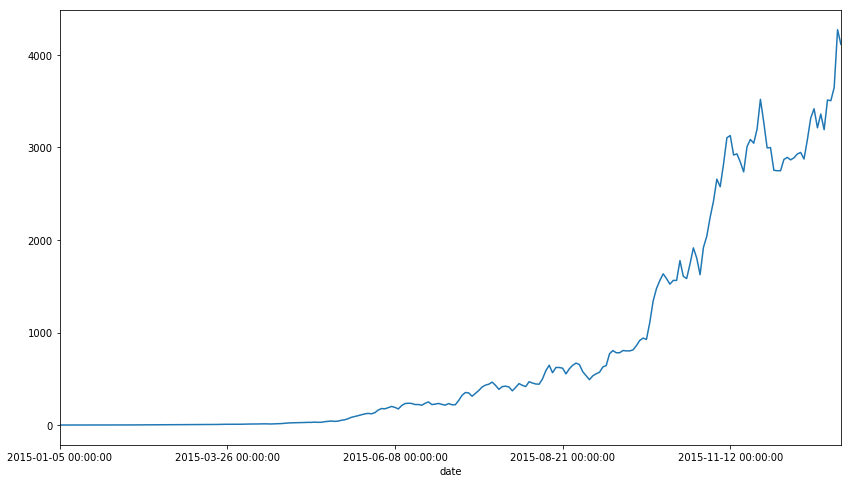

In [81]:
cum_value = valid_df["change"].cumprod()
cum_value.plot(figsize=(14,8))